In [1]:
import torch
import torch.nn as nn
from torchvision import models, datasets, transforms
import matplotlib.pyplot as plt
from tensorflow.keras.applications.imagenet_utils import decode_predictions
import numpy as np
from PIL import Image
import nltk
from nltk.corpus import stopwords
import operator
import regex as re

In [2]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
vgg_model = models.vgg16(pretrained=True)# return the vgg-16 model pretrained on ImageNet dataset.

In [4]:
def get_transforms():

    transform_normal = transforms.Compose([
            transforms.ToTensor() # convert numpy.array to tensor
            ])
    
    transform = transforms.Compose([
            transforms.Resize(256), 
            transforms.CenterCrop(224), # resize the image to 224x224
            transforms.ToTensor()])    
    
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    
    transform_normalize = transforms.Compose([
            transforms.Resize(256), 
            transforms.CenterCrop(224), # resize the image to 224x224
            transforms.ToTensor(), # convert numpy.array to tensor
            normalize])
    
    return transform_normal, transform, transform_normalize

In [5]:
def visualize_img(img_path, normal = True, normalized = False):
    
    img = Image.open(img_path)
    
    a,b,c = get_transforms()
    
    if not normal:    
        if normalized:
            image = c(img)
        else:
            image = b(img)
    else:
        image = a(img)
    
    # convert tis image to numpy array
    image = np.array(image)
    

    # transpose from shape of (3,,) to shape of (,,3)
    image = image.transpose(1, 2, 0)

    # display the normalized image
    plt.imshow(image)

In [6]:
# import urllib.request
# urllib.request.urlretrieve("https://stat.overdrive.in/wp-content/odgallery/2020/06/57263_2020_Mercedes_Benz_GLS.jpg", "image_car.jpeg")

In [7]:
# Define preprocessing function of the input images
def preprocess_image(dir_path):
    _, transform, transform_normalize = get_transforms()

    dataset = datasets.ImageFolder(dir_path, transform_normalize) #normalize the tensor
    
    rgb_dataset = datasets.ImageFolder(dir_path, transform)

    return (dataset, rgb_dataset)

In [8]:
dir_path = "../input/gradcam/GradCam-master/data/" 
dataset, rgb_dataset = preprocess_image(dir_path)

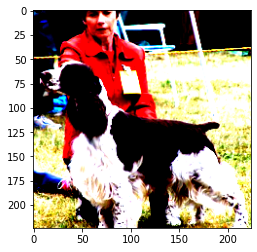

In [9]:
index = 4
visualize_img(dataset.imgs[index][0], normal = False, normalized = True)

Predict the label of the input image, and print the top-3 possible classes

In [10]:
output = vgg_model(dataset[index][0].view(1, 3, 224, 224))

values, indices = torch.topk(output, 3)
print("Top 3-classes:", indices[0].numpy())
print("Raw class scores:", values[0].detach().numpy())

Top 3-classes: [217 218 220]
Raw class scores: [21.993317 21.28298  21.086138]


### Grad-CAM 

In [11]:
import torch.nn.functional as F
from torch.autograd import grad

class Grad_CAM():
    def __init__(self, model):
        self.model = model
        self.activations = None
        self.gradient = None
        
        # register hooks to capture the feature_map gradients
        def forward_hook(model, input, output):
            self.activations = output[0]                       
            
        def backward_hook(model, grad_input, grad_output):
            self.gradient = grad_output[0][0]                      
            
        feat_map = model.features[29]         ####### Relu layer
        feat_map.register_forward_hook(forward_hook)
        feat_map.register_backward_hook(backward_hook)
        
    def get_grad_cam(self, img, indices = None):
        self.model.eval()
        out = self.model(img)         ### 1*1000
        num_features = self.activations.size()[0]    #### 512 *14*14
        topk = 3  
        if indices == None:
            values, indices = torch.topk(out, topk)
        else:
            values = torch.tensor([np.array(range(4,1,-1))])
            indices = torch.tensor([indices])
        # Compute 14x14 heatmaps
        heatmaps = torch.zeros(topk,14,14)
        for i,c in enumerate(indices[0]):
            self.model.zero_grad()
            out[0,c].backward(retain_graph=True)             #### 512 *14*14
            # feature importance
            feature_importance = self.gradient.mean(dim=[1,2])         #######  512
            # pixel importance
            for f in range(num_features):
                heatmaps[i] += feature_importance[f] * self.activations[f]      ### int * [14*14]    512*14*14
            heatmaps[i] = F.relu(heatmaps[i])
            heatmaps[i] /= torch.max(heatmaps[i])
#             print(heatmaps[i].shape,feature_importance.shape , self.activations.shape, self.gradient.shape)
        # Upsample to 224x224
        large_heatmaps = F.interpolate(heatmaps.expand((1,topk,14,14)), (224,224), mode='bilinear')
        return large_heatmaps[0].data.numpy(), values.data.numpy()[0], indices.data.numpy()[0]

### Visualization routine

In [12]:
def get_titles(values, indices):
    predictions = np.zeros((1,1000))
    predictions[0,indices] = values
    decoded = decode_predictions(predictions, top=3)[0]
    return [decoded[0][1],decoded[1][1],decoded[2][1]]

def plot_heatmaps(img, heatmaps, values = None, indices = None):
    fig, axs = plt.subplots(figsize=(18, 5), ncols=4)
    for k in range(1,4):
        ax = axs[k]
        ax.imshow(img)
        h = ax.imshow(heatmaps[k-1], cmap='jet', alpha=0.4)        
        title = 'Top '+str(k)
        if values is not None and indices is not None:
            title += '\nclass '+str(indices[k-1])
            title += '    score '+str(np.round(values[k-1],2))
        ax.set_title(title, fontsize=18)
        ax.set_xticks([])
        ax.set_yticks([])
        cbar = fig.colorbar(h, ax=ax, )
        cbar.ax.tick_params(labelsize=14)
    ax = axs[0]
    ax.imshow(img)
    title = 'Orignal image'
    ax.set_title(title, fontsize=18)
    fig.tight_layout()
    titles = get_titles(values, indices)
    suptitle = '\nTop 1: '+titles[0]+'\nTop 2: '+titles[1]+'\nTop 3: '+titles[2]
    fig.suptitle(suptitle, x=0.4, y=1.3, fontsize=20, ha='left', va='top')
    return fig

### Compute heatmaps for all images

  0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
100%|██████████| 2/2 [00:05<00:00,  2.58s/it]


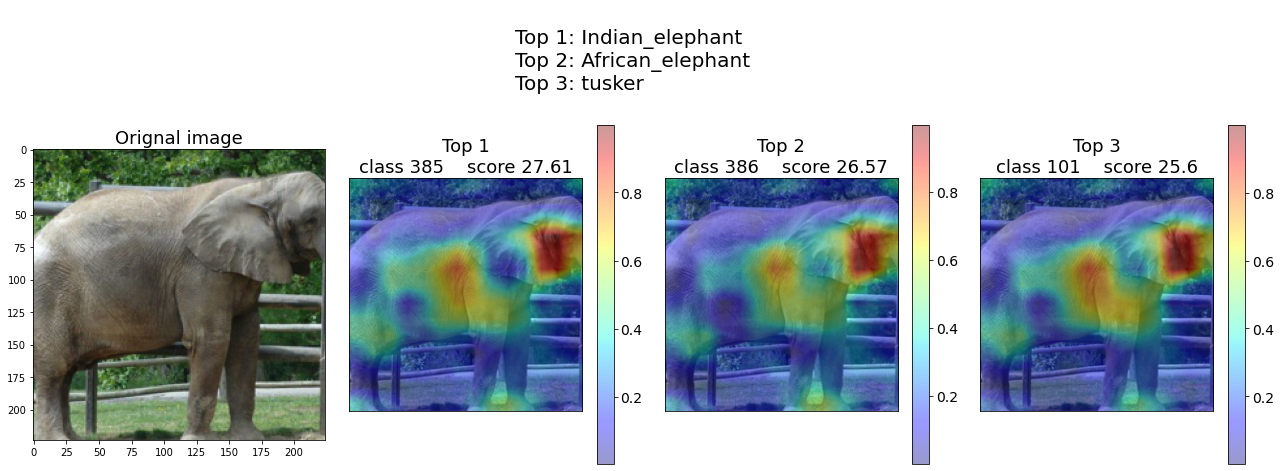

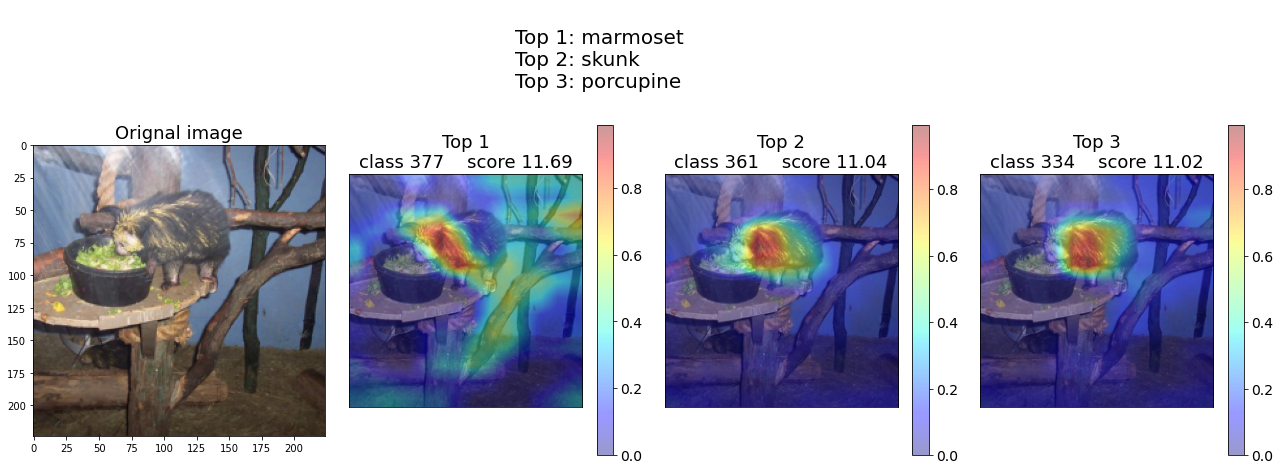

In [13]:
from tqdm import tqdm 
import cv2
from numpy.linalg import norm

cam = Grad_CAM(vgg_model)

for index in tqdm(range(len(dataset)//8)):
    # read an image
    img = dataset[index][0].view(1, 3, 224, 224)
    
    # Compute the gradients & heatmaps
    heatmaps, values, indices = cam.get_grad_cam(img)
    
    # Visualize the heatmaps
    rgb_img = np.transpose(rgb_dataset[index][0].view(1, 3, 224, 224).numpy()[0], [1,2,0])
    fig = plot_heatmaps(rgb_img, heatmaps, values, indices)
    fig.show()

In [14]:
emmbed_dict = {}
embed_glv = []
word_2_ind = {}
ind_2_word = {}
with open('../input/glove6b/glove.6B.300d.txt','r') as f:
    for idx,line in enumerate(f):
        values = line.split()
        word = values[0]
        word_2_ind[word] = idx
        ind_2_word[idx] = word
        vector = np.asarray(values[1:],'float32')
        embed_glv.append(vector)
        emmbed_dict[word]=vector

In [15]:
with open('../input/imagenet-classes/image_net_class.txt') as f:
    lines = f.readlines()
imgNet_classes = []
for ix, line in enumerate(lines):
    newlist = re.split('([0-9]+)', line)[2].split(',')[0].strip()
    imgNet_classes.append(newlist)

In [16]:
fnl_embeds = {}
for ix , lbl in enumerate(tqdm(imgNet_classes)):
    temp = np.zeros((emmbed_dict['vineet'].shape))
    c = 0
    x = lbl.split(' ')
    words = []
    for wo in x:
        words.extend(wo.split('-'))
    for word in words: 
        try:
            c=c+1
            temp+= emmbed_dict[word.lower()]
        except:
#             print(word)
            pass
    temp = temp/c
    if ix == 134 or ix == 638:
        fnl_embeds[lbl+' '+lbl] = temp
    fnl_embeds[lbl] = temp

100%|██████████| 1000/1000 [00:00<00:00, 99695.85it/s]


In [17]:
def get_name(sent):
    sent = re.sub(r'[^\w\s]', '', sent)
    filtered_words = [word for word in nltk.word_tokenize(sent.lower()) if word not in stopwords.words('english')]
    test_embed = 0
    for word in filtered_words:
        test_embed+=emmbed_dict[word]
    test_embed/=len(filtered_words)
#     test_embed = emmbed_dict[filtered_words[-1]]
    sims = {}
    for key, val_emb in fnl_embeds.items():
        sim = np.dot(test_embed,val_emb)/((norm(test_embed)*norm(val_emb))+1e-5)
        sims[key] = sim
    sorted_sim = dict( sorted(sims.items(), key=operator.itemgetter(1),reverse=True))
    class_name = list(sorted_sim)[:3]
    indexes = []
    for i in class_name:
        indexes.append(imgNet_classes.index(i))
    return indexes

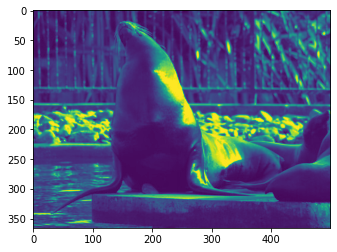

In [18]:
index = 15
plt.imshow(Image.open(dataset.imgs[index][0]))

In [19]:
test_sent = input('Enter Question : ')
indices = get_name(test_sent)

Enter Question :  Where is punching bag?


Question:  Where is punching bag?


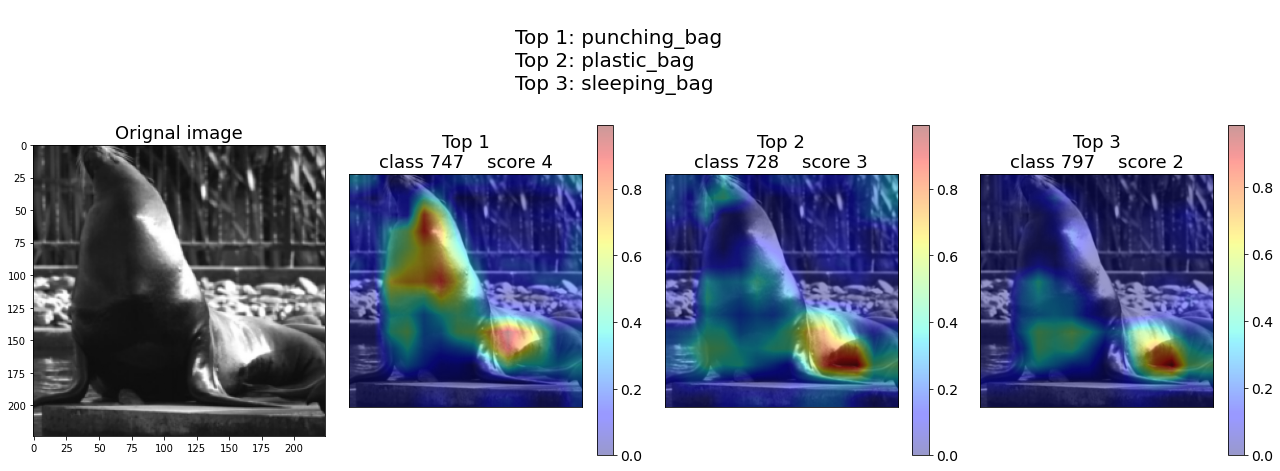

In [20]:
print('Question: ', test_sent)
img = dataset[index][0].view(1, 3, 224, 224)
heatmaps, values, indx = cam.get_grad_cam(img,indices)
rgb_img = np.transpose(rgb_dataset[index][0].view(1, 3, 224, 224).numpy()[0], [1,2,0])
fig = plot_heatmaps(rgb_img, heatmaps, values, indx)
fig.show()

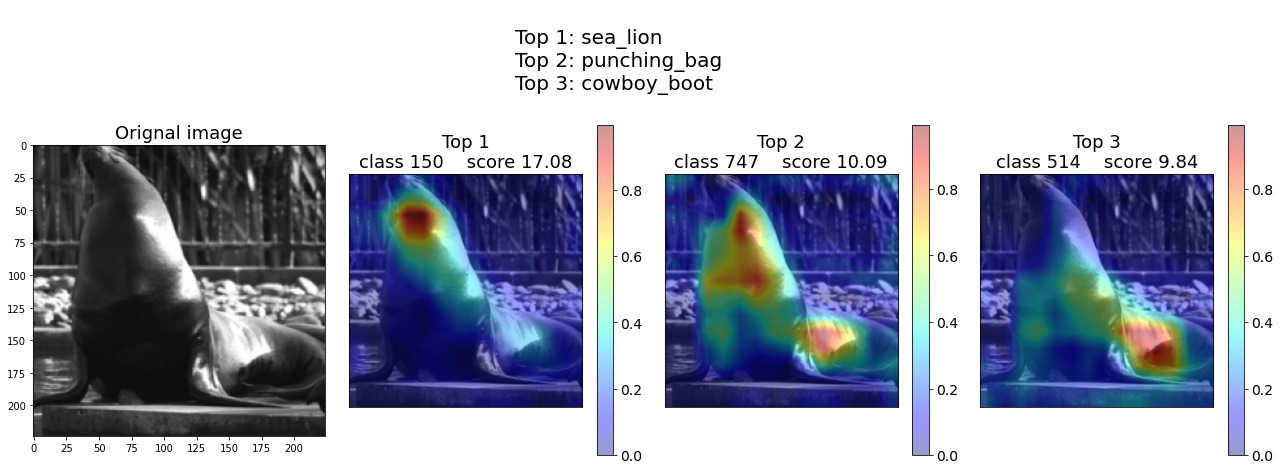

In [21]:
img = dataset[index][0].view(1, 3, 224, 224)
heatmaps, values, indx = cam.get_grad_cam(img)
rgb_img = np.transpose(rgb_dataset[index][0].view(1, 3, 224, 224).numpy()[0], [1,2,0])
fig = plot_heatmaps(rgb_img, heatmaps, values, indx)
fig.show()